In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0.2 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)


# Load and process data

In [3]:
# read data from csv file
trainset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/trainset.csv')
testset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/testset.csv')
print(trainset.shape)
print(testset.shape)

(80000, 15)
(20000, 15)


In [4]:
trainset

,0_Ca,0_Cl,0_Na,0_K,0_N5,1_Ca,1_Cl,1_Na,1_K,1_N5,out_Ca,out_Cl,out_Na,out_K,out_N5
0,0.341575,1.159034,0.012636,0.451710,0.794808,0.347226,0.116634,0.755911,0.674340,1.359338,0.3233,1.1590,0.02901,0.4719,0.79480
1,0.638607,0.558054,1.231009,0.243433,1.132821,0.038278,0.185744,0.734268,1.464984,1.489907,0.4584,0.5581,1.24700,0.5882,1.13300
2,0.787981,0.763241,0.349968,0.738449,1.452716,1.117356,0.110285,0.393380,0.282715,1.466671,0.8053,0.7632,0.34980,0.7038,1.45300
3,0.466115,0.948450,0.942671,1.051085,1.358636,0.470234,0.252135,0.914662,1.318543,1.076570,0.4558,0.9484,0.94180,1.0730,1.35900
4,0.452663,0.644895,1.360873,0.991130,0.162887,1.361588,1.475943,0.637112,0.397679,1.414160,0.4939,0.6449,1.34300,0.9266,0.16290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.796601,0.398041,1.132371,0.996845,0.094560,1.074895,1.055513,0.777877,0.870241,0.361988,0.8083,0.3980,1.12600,0.9802,0.09456
79996,0.942419,1.456538,1.164360,0.775981,0.069458,1.024540,1.025283,0.144121,1.438743,0.241862,0.9305,1.4570,1.15000,0.8141,0.06946
79997,1.095302,0.438446,1.335379,0.365207,0.273701,0.765942,0.880543,1.152310,1.119219,1.104459,1.0670,0.4384,1.33500,0.4223,0.27370
79998,0.310626,0.661302,0.192742,1.280823,0.931653,0.199012,0.072267,0.870017,0.563615,0.006399,0.3275,0.6613,0.21380,1.2260,0.93170


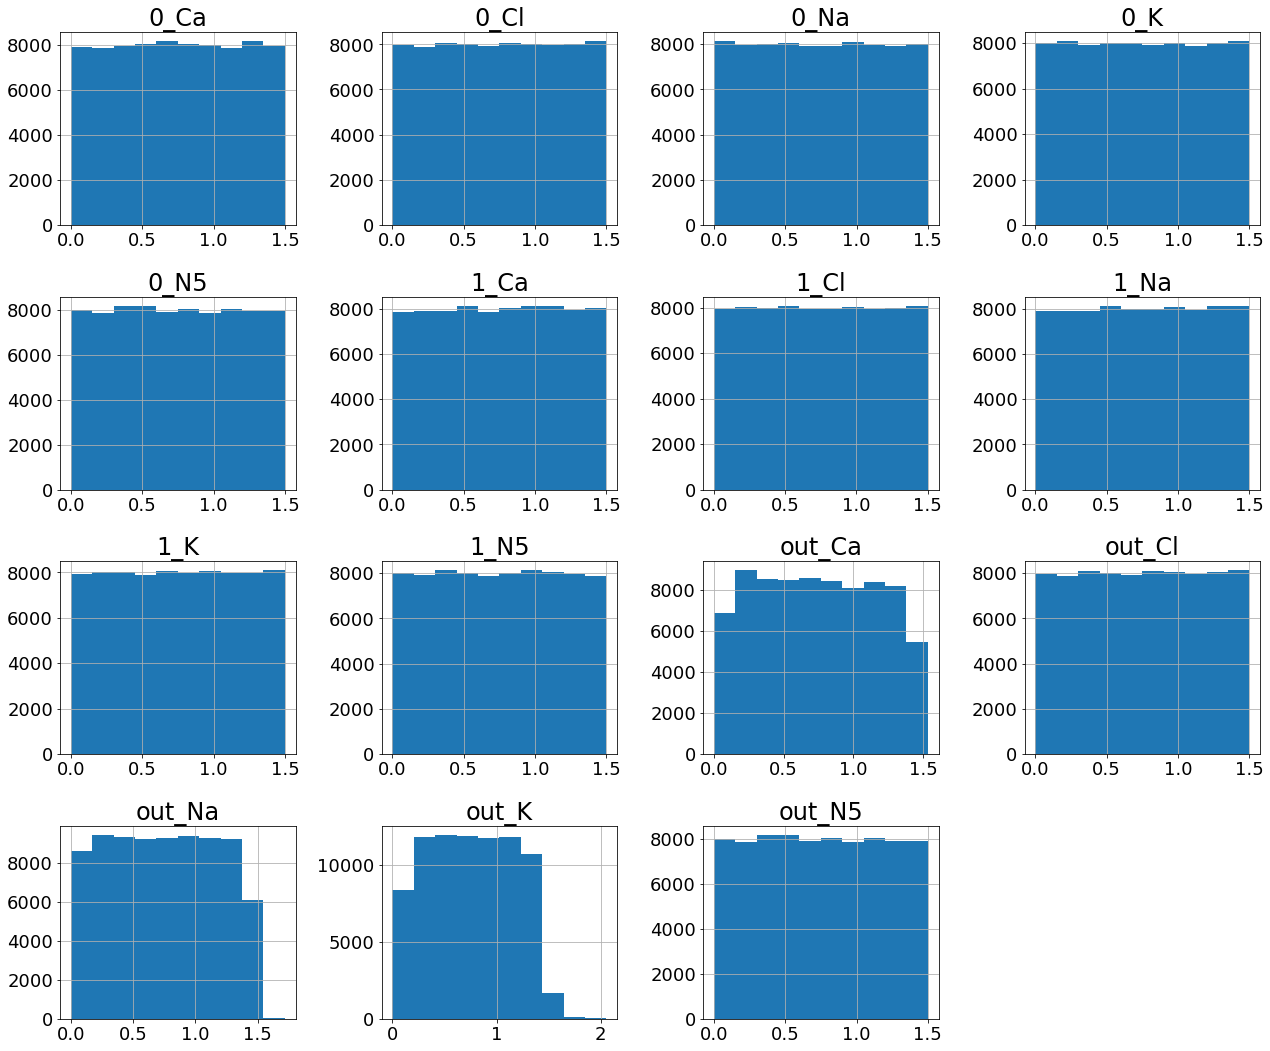

In [5]:
trainset.hist(figsize=(18, 15));
plt.tight_layout()

In [6]:
# split x and y
X_train = trainset.iloc[:, [0,2,3,5,7,8]].values 
y_train = trainset.iloc[:, [10, 12, 13]].values
X_test = testset.iloc[:, [0,2,3,5,7,8]].values 
y_test = testset.iloc[:, [10, 12, 13]].values

# Name variables
inputs = [list(trainset)[i] for i in [0,2,3,5,7,8]] 
outputs = [list(trainset)[i] for i in [10, 12, 13]] # do not work for list -> list(trainset)[10, 12, 13]

In [7]:
print('Inputs: ', inputs)
print('Outputs: ', outputs)
print('X_train instances: ', X_train.shape)
print('X_test instances: ', X_test.shape)
print('y_train instances: ', y_train.shape)
print('y_test instances: ', y_test.shape)

Inputs:  ['0_Ca', '0_Na', '0_K', '1_Ca', '1_Na', '1_K']
Outputs:  ['out_Ca', 'out_Na', 'out_K']
X_train instances:  (80000, 6)
X_test instances:  (20000, 6)
y_train instances:  (80000, 3)
y_test instances:  (20000, 3)


## Normalize data

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

norm_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler((-1,1))),
    ])

X_train_norm = norm_pipeline.fit_transform(X_train)
X_test_norm = norm_pipeline.transform(X_test)

# Fine Tuning

## sklearn XGB

In [10]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try combinations of hyperparameters
    {'subsample': [0.2, 0.6, 1.0], 
     'learning_rate': [0.01, 0.05, 0.1],
     'n_estimators': [300, 400, 500], 
     'max_depth': [3, 5, 10],
     'colsample_bytree': [0.6, 0.8, 1.0],
     'reg_lambda': [10, 1.0, 1e-1]}  
    ]

# train across 3 folds
grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', n_jobs=3, random_state=42),
                           param_grid, 
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, 
                           verbose = 1,
                           n_jobs= 25)

start = time.time()
grid_search.fit(X_train_norm, y_train)
print("Run time = ", time.time()-start)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Run time =  2972.2643139362335


In [11]:
print(f"best parameters: {grid_search.best_params_}")
print(f"best score:      {-grid_search.best_score_:0.5f} (+/-{grid_search.cv_results_['std_test_score'][grid_search.best_index_]:0.5f})")
    

best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 1.0, 'subsample': 0.6}
best score:      0.00002 (+/-0.00000)


In [12]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score
616,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",1,-0.000010,7.895768e-08,-0.000024,8.009967e-07
613,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",2,-0.000012,4.042326e-08,-0.000024,8.024070e-07
615,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",3,-0.000014,3.018173e-08,-0.000024,5.285626e-07
639,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",4,-0.000010,6.901108e-08,-0.000025,6.062880e-07
619,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",5,-0.000010,8.424379e-08,-0.000025,1.127514e-06
...,...,...,...,...,...,...
55,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",725,-0.009480,2.539310e-04,-0.010487,1.894398e-04
58,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",726,-0.009010,2.451214e-04,-0.010508,1.980507e-04
1,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",727,-0.010490,2.829090e-04,-0.010554,2.283351e-04
54,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",728,-0.010019,2.694410e-04,-0.010682,1.966490e-04


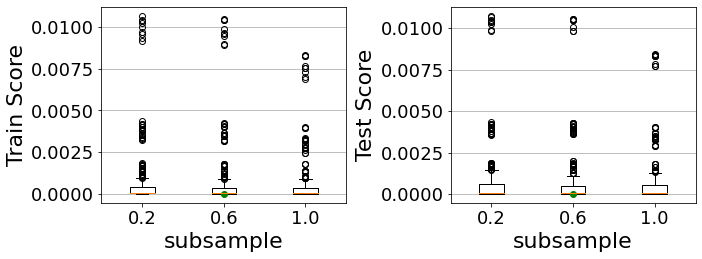

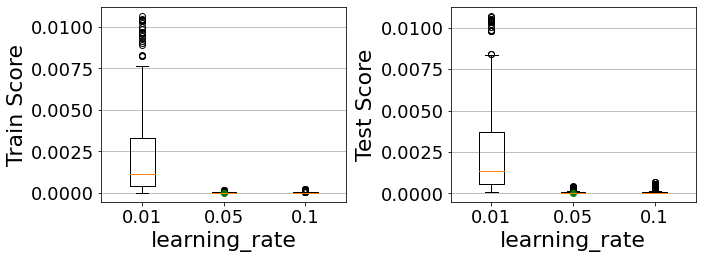

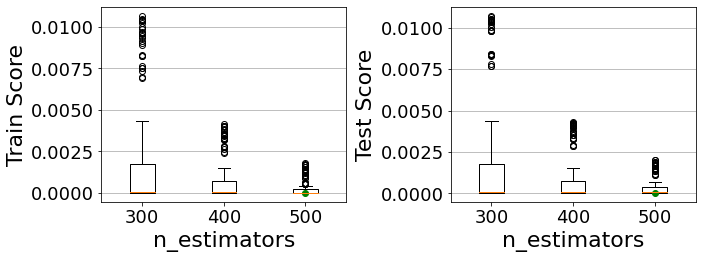

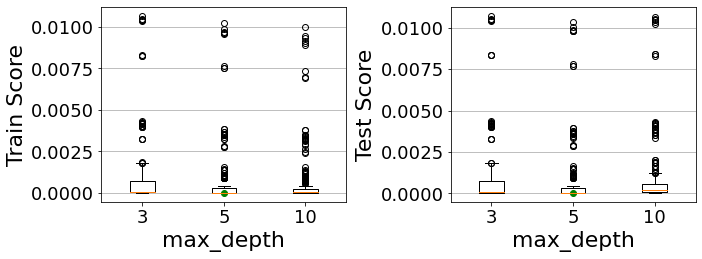

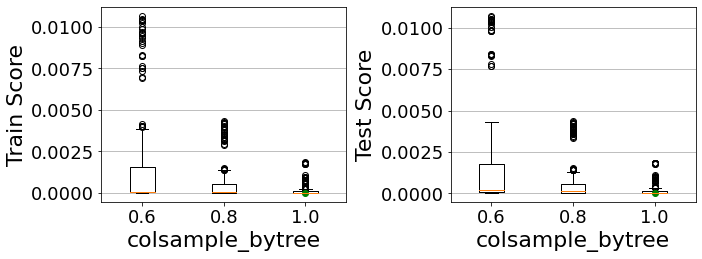

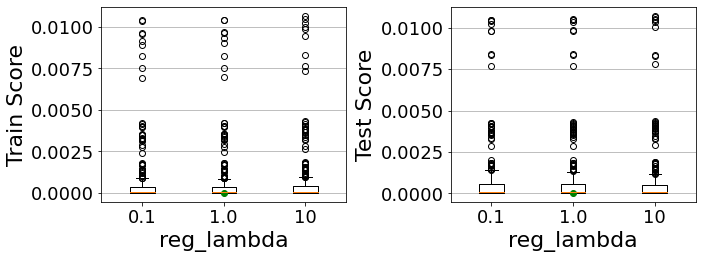

In [13]:
for param_name in param_grid[0]:

    params = sorted(results_df['param_' + param_name].unique())
    means_train = [-results_df[results_df['param_' + param_name] == p]['mean_train_score'] for p in params]
    means_test = [-results_df[results_df['param_' + param_name] == p]['mean_test_score'] for p in params]

    # plot
    fig, axes = plt.subplots(1,2, figsize=(10,4))

    axes[0].boxplot(means_train)
    axes[0].plot(params.index(grid_search.best_params_[param_name])+1,
                 -grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 'go')
    axes[0].set_xlabel(param_name)
    axes[0].set_ylabel('Train Score')
    
    axes[1].boxplot(means_test)
    axes[1].plot(params.index(grid_search.best_params_[param_name])+1,
                 -grid_search.cv_results_['mean_test_score'][grid_search.best_index_], 'go')    
    axes[1].set_xlabel(param_name)
    axes[1].set_ylabel('Test Score')
    
    # adding horizontal grid lines
    for ax in axes:
        ax.yaxis.grid(True)
        ax.set_xticks([x+1 for x in range(len(params))], labels=list(map(str, params)))
    
    plt.tight_layout()
    plt.show()

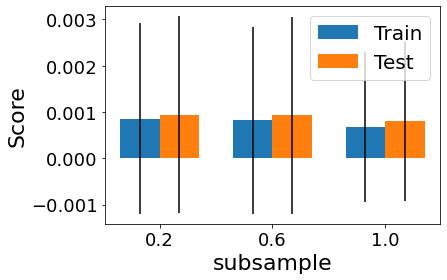

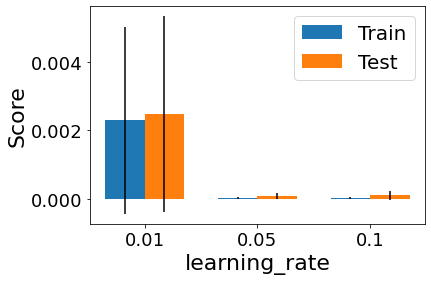

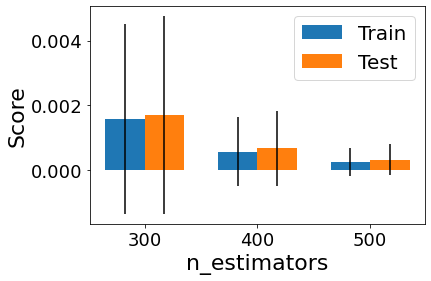

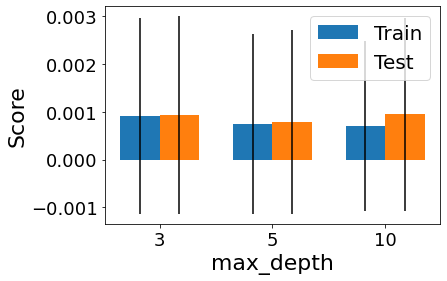

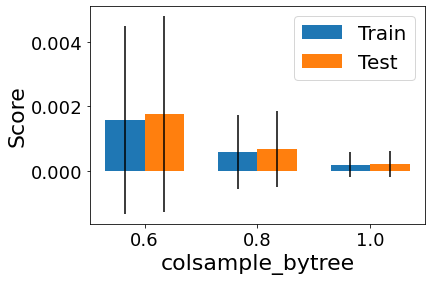

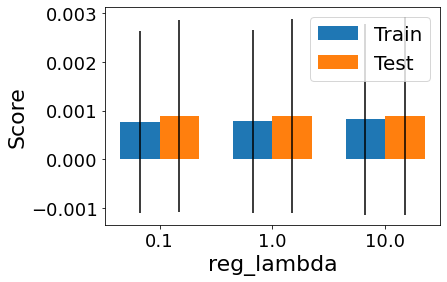

In [14]:
for param_name in param_grid[0]:
    
    results_dfg = results_df.groupby('param_' + param_name)
    params = results_dfg.groups.keys() # or params = results_df['param_' + param_name].unique()
    means_train = -results_dfg.mean()['mean_train_score']
    stds_train = results_dfg.std()['mean_train_score']
    means_test = -results_dfg.mean()['mean_test_score']
    stds_test = results_dfg.std()['mean_test_score']

    # plot
    fig, ax = plt.subplots()
    
    x = np.arange(len(params))  # the label locations
    width = 0.35  # the width of the bars

    ax.bar(x - width/2, means_train, width, yerr=stds_train, label = 'Train')
    ax.bar(x + width/2, means_test, width, yerr=stds_test, label = 'Test')
    ax.set_xticks(x, list(map(str, params)))
    ax.set_xlabel(param_name)
    ax.set_ylabel('Score')
    ax.legend()
    plt.show()

In [15]:
reg_best = grid_search.best_estimator_

print(grid_search.best_params_, end='\n')
print(grid_search.best_estimator_)

{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 1.0, 'subsample': 0.6}
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=3,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1.0, ...)


In [16]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.10354819206098904 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 10, 'subsample': 0.2}
0.10273341002117876 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 10, 'subsample': 0.6}
0.09154065690447895 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 10, 'subsample': 1.0}
0.10230724811795633 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.0, 'subsample': 0.2}
0.10231585930145178 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.0, 'subsample': 0.6}
0.09129367371908349 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.0, 'subsample': 1.0}
0.10218082762934114 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 0.1, 'subsample': 0.2}
0.

In [17]:
sorted(zip(np.sqrt(-cvres["mean_test_score"]), cvres["params"]), key=lambda cvres: cvres[0], reverse=False)

[(0.004872444771350817,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 5,
   'n_estimators': 500,
   'reg_lambda': 1.0,
   'subsample': 0.6}),
 (0.00490822042905058,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 5,
   'n_estimators': 500,
   'reg_lambda': 10,
   'subsample': 0.6}),
 (0.004941337466057725,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 5,
   'n_estimators': 500,
   'reg_lambda': 1.0,
   'subsample': 0.2}),
 (0.004968034421886189,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 10,
   'n_estimators': 500,
   'reg_lambda': 10,
   'subsample': 0.2}),
 (0.005034535623100373,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 5,
   'n_estimators': 500,
   'reg_lambda': 0.1,
   'subsample': 0.6}),
 (0.005047010781552695,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 5,
   'n_estimators': 400,
   'reg_lambda': 1.0,
   'subsample': 0.6}),
 (0.00

In [18]:
sorted(zip(reg_best.feature_importances_, inputs), reverse=True)

[(0.39931, '0_Na'),
 (0.34197274, '0_K'),
 (0.25028178, '0_Ca'),
 (0.004299259, '1_K'),
 (0.0037749312, '1_Ca'),
 (0.00036123555, '1_Na')]

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

start = time.time()
y_train_pred = reg_best.predict(X_train_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_train, y_train_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_train, y_train_pred)
print('mae: ',mae)

r2_model = r2_score(y_train, y_train_pred)
print('\nR2: ',r2_model)

time =  -0.7257900238037109

mse:  9.96532885066107e-06
rmse:  0.003156790910190453
mae:  0.002174229431057852

R2:  0.9999410955856024


In [28]:
start = time.time()
y_test_pred = reg_best.predict(X_test_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_test, y_test_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_test, y_test_pred)
print('mae: ',mae)

r2_model = r2_score(y_test, y_test_pred)
print('\nR2: ',r2_model)

time =  -0.19549894332885742

mse:  1.980493758073278e-05
rmse:  0.004450273877047656
mae:  0.0025004586181196697

R2:  0.9998834196853963


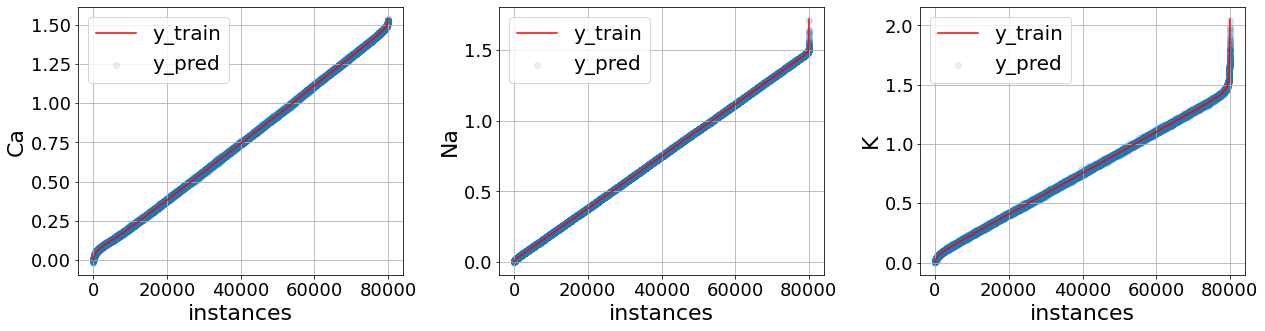

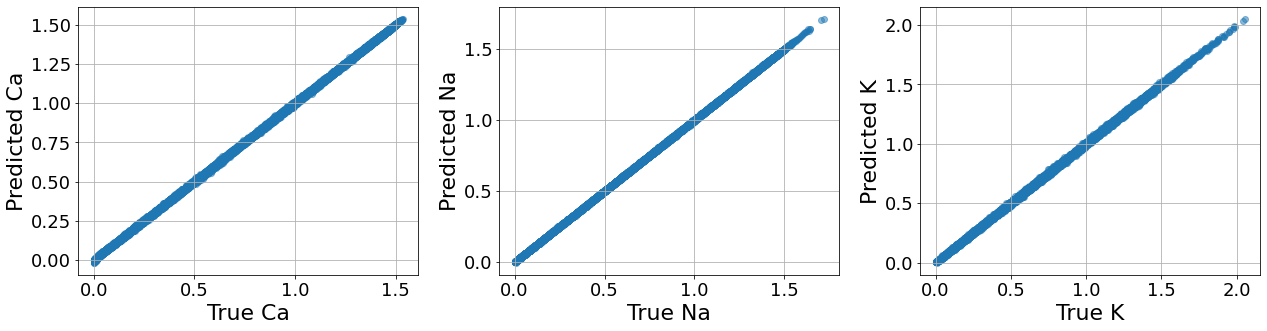

In [29]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_train[:,i]
    aux_pred = y_train_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_train[:,i], y_train_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

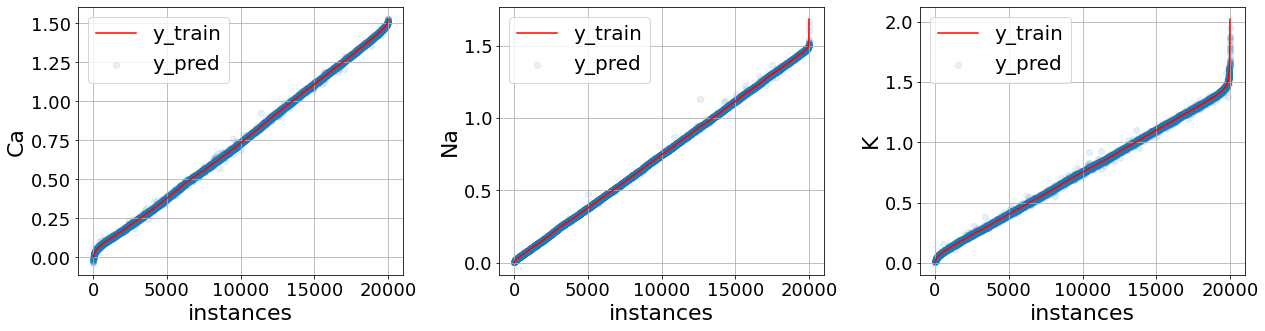

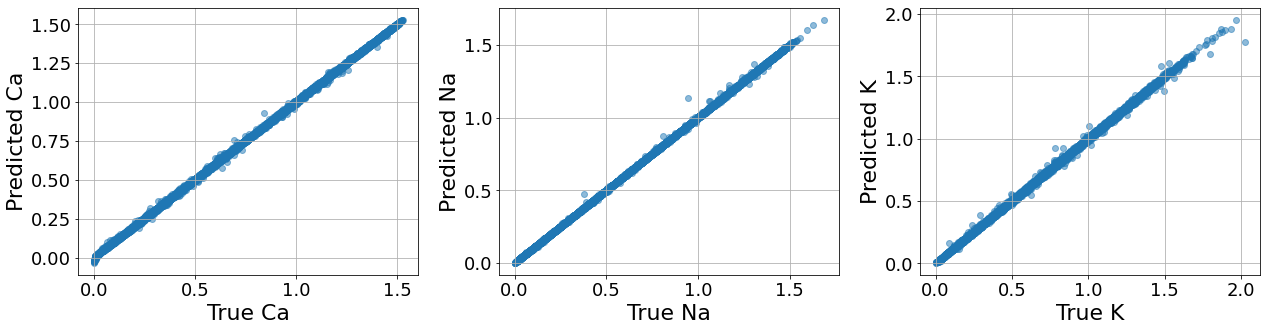

In [30]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_test[:,i]
    aux_pred = y_test_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[:,i], y_test_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

## Checking charge constraint

In [24]:
charge_in = 2*X_train[:, 0]+X_train[:, 1]+X_train[:, 2]
charge_out = 2*y_train_pred[:, 0]+y_train_pred[:, 1]+y_train_pred[:, 2]

mean_absolute_error(charge_in, charge_out)  

0.005452536934090502

In [25]:
charge_in = 2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]
charge_out = 2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2]

mean_absolute_error(charge_in, charge_out)  

0.006132702678405575

## Run time

In [26]:
start = time.time()
for i in range(1000):  
    reg_best.predict(X_test_norm[0:1])
end = time.time()
print("time = ", (start - end)/1000)
print()

time =  -0.0008300762176513672



## Model persistence

In [27]:
final_model = Pipeline([
        ("norm", norm_pipeline),
        ("reg", reg_best)
        ])

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model.predict(X_test))))

rmse:  0.004450273877047656


In [9]:
import joblib
from sklearn.metrics import mean_squared_error

#joblib.dump(final_model, "XGBmodel.pkl")
final_model_loaded = joblib.load("XGBmodel.pkl") 

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model_loaded.predict(X_test))))

rmse:  0.004450273877047656


In [10]:
# Add Physics-constrained

y_test_pred = final_model_loaded.predict(X_test)
y_test_pred = (y_test_pred.T*(2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]) \
                         /(2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2])).T
print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

rmse: 0.003957311739928482


In [11]:
start = time.time()
final_model_loaded = joblib.load("XGBmodel.pkl") 
end_load = time.time()
print('Load time = ', end_load - start)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1])
end = time.time()    
print('Prediction time 1 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1000])
end = time.time()    
print('Prediction time 1000 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:10000])
end = time.time()    
print('Prediction time 10,000 = ', (end - start)/1000)

Load time =  0.07379674911499023
Prediction time 1 =  0.0009283566474914551
Prediction time 1000 =  0.010980558156967163
Prediction time 10,000 =  0.08933913850784302


## Model persistence Multi-Threading

In [14]:
import xgboost as xgb

reg_best2 = xgb.XGBRegressor(objective='reg:squarederror', 
                             colsample_bytree= 1.0, 
                             learning_rate= 0.05, 
                             max_depth= 5, 
                             n_estimators= 500, 
                             reg_lambda= 1.0,
                             subsample= 0.6,
                             n_jobs=-1, 
                             random_state=42)

start = time.time()
reg_best2.fit(X_train_norm, y_train)
print("Run time = ", time.time()-start)

Run time =  39.05390214920044


In [15]:
final_model = Pipeline([
        ("norm", norm_pipeline),
        ("reg", reg_best2)
        ])

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model.predict(X_test))))

rmse:  0.004450273877047656


In [17]:
import joblib
from sklearn.metrics import mean_squared_error

joblib.dump(final_model, "XGBmodel_multithread.pkl")
final_model_loaded = joblib.load("XGBmodel_multithread.pkl") 

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model_loaded.predict(X_test))))

rmse:  0.004450273877047656


In [18]:
start = time.time()
final_model_loaded = joblib.load("XGBmodel_multithread.pkl") 
end_load = time.time()
print('Load time = ', end_load - start)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1])
end = time.time()    
print('Prediction time 1 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1000])
end = time.time()    
print('Prediction time 1000 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:10000])
end = time.time()    
print('Prediction time 10,000 = ', (end - start)/1000)

Load time =  0.04586458206176758
Prediction time 1 =  0.0012922396659851075
Prediction time 1000 =  0.005998144865036011
Prediction time 10,000 =  0.014698884725570679
